##Objectives


*   Dataset- Heart attack occurence. 
*   Define regression or classification problem. 
*   Choose evaluation metrics and create a baseline. 
*   Fit and evaluate a linear model.
*   Fit and evaluate a tree-based model.











In [ ]:
# category encoders. 
!pip install category_encoders==2.*
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 43 kB/s 
     |████████████████████████████████| 13.1 MB 6.8 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=1e7821224ba7e7c4d9aa0bb7425d2f447742115250999cf424bbbb843e00f3bf
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, plot_roc_curve,plot_confusion_matrix

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Boosted Models

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Permutation Importance
from sklearn.inspection import permutation_importance

# for displaying images and html
from IPython.display import Image
from IPython.core.display import HTML 

#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# Loading the data from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Heart_attack

/content/gdrive/My Drive/Heart_attack


##Data Wrangling

In [ ]:
def wrangle(filepath):
  df=pd.read_csv(filepath)

  # Create a new target column
  df['result'] = np.where(df['output']== 1,'affected','not_affected')
  df.drop(columns='output',inplace=True)
  #Assign the binary digits in "sex" column strings. 
  df['sex'] = df['sex'].apply(str)
  df['sex'].replace({"1":"Male",
                      "0":"Female"},
                      inplace= True)
  #Dropping columns that are not required.(permutation) 
  columns_to_drop = ['exng','restecg','chol','trtbps','oldpeak']
  df = df.drop(columns=columns_to_drop)

  df['normal_hr']= 100
  df['above_normal_hr'] = df['thalachh'] - df['normal_hr']
  return df
df= wrangle(filepath='heart.csv')

In [ ]:
df.head()

,age,sex,cp,fbs,thalachh,slp,caa,thall,result,normal_hr,above_normal_hr
0,63,Male,3,1,150,0,0,1,affected,100,50
1,37,Male,2,0,187,0,0,2,affected,100,87
2,41,Female,1,0,172,2,0,2,affected,100,72
3,56,Male,1,0,178,2,0,2,affected,100,78
4,57,Female,0,0,163,2,0,2,affected,100,63


In [ ]:
df.shape

(303, 11)

In [ ]:
df.dtypes

age                 int64
sex                object
cp                  int64
fbs                 int64
thalachh            int64
slp                 int64
caa                 int64
thall               int64
result             object
normal_hr           int64
above_normal_hr     int64
dtype: object

##Splitting Data

Splitting the dataset into target(y) and X. 

In [ ]:
y = df['result']
X = df.drop(columns=['result'])

Splitting the data further into train and validation sets.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.40, random_state=42)

Baseline accuracy

In [ ]:
print("Baseline Accuracy", y_train.value_counts(normalize=True)[0])

Baseline Accuracy 0.5248618784530387


Fitting and checking metrics of a Logistic model. 

In [ ]:
model_lr = make_pipeline(OrdinalEncoder(), 
                         SimpleImputer(), 
                         LogisticRegression(max_iter=500))

model_lr.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['sex'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'sex', 'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=500,
                                    multi_class='auto', n_jobs=None

Metrics of Logistic Model. 

In [ ]:
print("Train Accuracy", model_lr.score(X_train, y_train))
print("Validation Accuracy", model_lr.score(X_val, y_val))

Train Accuracy 0.856353591160221
Validation Accuracy 0.8114754098360656


Fitting a random forest model. 

In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100,max_depth=25,random_state=42)
)

model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['sex'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'sex', 'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=25, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
           

Metrics of Random Forest. 

In [ ]:
print('Random Forest Training Accuracy', model_rf.score(X_train, y_train))
print('Random Forest Validation Accuracy', model_rf.score(X_val, y_val))

Random Forest Training Accuracy 1.0
Random Forest Validation Accuracy 0.819672131147541


Hyperparameter Tuning. 

In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier()
)
param_grid = {
    'simpleimputer__strategy' :['mean','median'],
    'randomforestclassifier__max_depth': range(5,50,5),
    'randomforestclassifier__n_estimators': range(25, 150, 25)
}
model = RandomizedSearchCV(
    model_rf,
    param_distributions=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter=7
)
model.fit(X,y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.8150273224043716
Best params for `model`: {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 125, 'randomforestclassifier__max_depth': 5}


Bar plot showing the outcomes

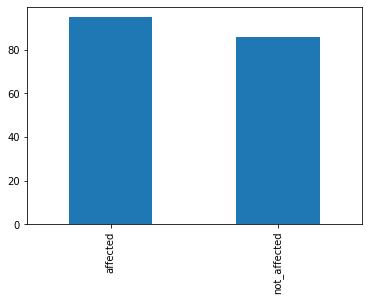

In [ ]:
y_train.value_counts().plot(kind='bar')

Confusion matrix

              precision    recall  f1-score   support

    affected       0.85      0.83      0.84        70
not_affected       0.78      0.81      0.79        52

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122



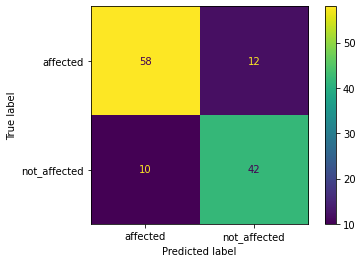

In [ ]:
print(classification_report(y_val,model_rf.predict(X_val)))
plot_confusion_matrix(model_rf,X_val,y_val);

              precision    recall  f1-score   support

    affected       0.90      0.93      0.92        70
not_affected       0.90      0.87      0.88        52

    accuracy                           0.90       122
   macro avg       0.90      0.90      0.90       122
weighted avg       0.90      0.90      0.90       122



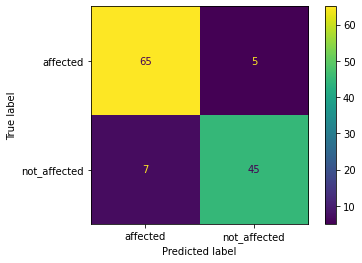

In [ ]:
print(classification_report(y_val,model.predict(X_val)))
plot_confusion_matrix(model,X_val,y_val);

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
features = ['cp', 'thall']

interaction = pdp_interact(
    model=model, 
    dataset=X_val, 
    model_features=X_val.columns,
    features=features
)

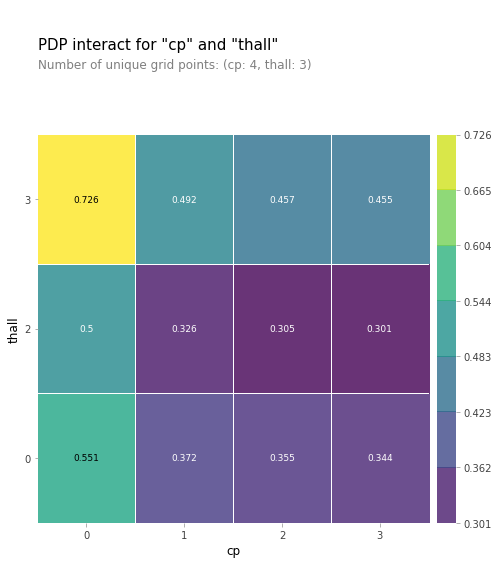

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);